In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as smi
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statistics import mean
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, GRU, Dropout, Conv1D, MaxPooling1D, Flatten, RepeatVector
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from hyperopt import hp, Trials, fmin, tpe
import joblib
import warnings
warnings.simplefilter('ignore')

In [2]:
df=pd.read_csv(r'E:\A aPython Programms\Data1\Bank.csv')
df.head(5)

,Date,AXISBANK,AXISVOL,BAJAJFIN,BAJAJFINVOL,BOB,BOBVOL,FEDBANK,FEDVOL,HDFC,...,KOTAK,KOTAKVOL,PNB,PNBVOL,SBI,SBIVOL,REC,RECVOL,PIRAMAL,PIRAMALVOL
0,02-01-2009,108.379997,14261265,6.310420,141738,57.340000,1700495,16.889999,1359910,101.565002,...,97.900002,6258884,106.430000,2973855,133.184998,24161650,29.587500,9574565,134.700485,222908
1,05-01-2009,112.019997,9165605,6.504736,1120575,58.860001,2687100,17.129999,4379460,104.410004,...,99.637497,5956956,107.160004,3037185,136.080002,26931910,30.562500,8844514,136.025497,14449
2,06-01-2009,113.949997,12893855,6.660189,312830,57.750000,3162520,16.760000,1930260,110.040001,...,96.712502,9015300,106.089996,4110100,132.285004,35970960,29.831249,1078005,133.516418,102783
3,07-01-2009,104.419998,10571555,6.150109,166223,54.939999,5602350,16.459999,2251090,100.925003,...,90.762497,6482408,97.660004,6538860,124.004997,37268580,28.424999,5624090,131.853104,24863
4,09-01-2009,97.320000,25173105,6.048093,95905,54.689999,1806325,16.004999,4046570,101.750000,...,86.125000,5076276,97.129997,3834090,122.110001,24996510,28.818750,6157634,129.654144,301873


In [3]:
feature_columns = ['ICICI', 'ICICIVOL']
target_column = ['ICICI']
features = df[feature_columns]
target = df[target_column].shift(-2)

new_data1 = 1099.65
target.iloc[-2, 0] = new_data1

new_data2 = 1081.20
target.iloc[-1, 0] = new_data2
target.tail(5)

,ICICI
3748,1083.699951
3749,1083.750000
3750,1093.300049
3751,1099.650000
3752,1081.200000


In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.values.reshape(-1, 1))
target=target.dropna()

n_steps = 5 # Number of timesteps to look back
X, y = [], []

for i in range(n_steps, len(scaled_features)):
    X.append(scaled_features[i-n_steps:i])
    y.append(scaled_target[i])

X = np.array(X)
y = np.array(y)

split=int(0.8*len(X))
X_train, y_train= X[:split], y[:split]
X_test, y_test= X[split:], y[split:]

In [5]:
model_lstm = load_model('model_lstm_icici2_0.9817.keras')
model_lstm.predict(X_test)

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae_n=mean_absolute_error(y_test, predictions_lstm)
print(f"MAE_normalizeddata: {mae_n:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R2: 0.9758
MAPE: 0.0194
RMSE: 20.1849
RMSE_normalizeddata: 0.0192
MAE_normalizeddata: 0.0150
MAE: 15.7547


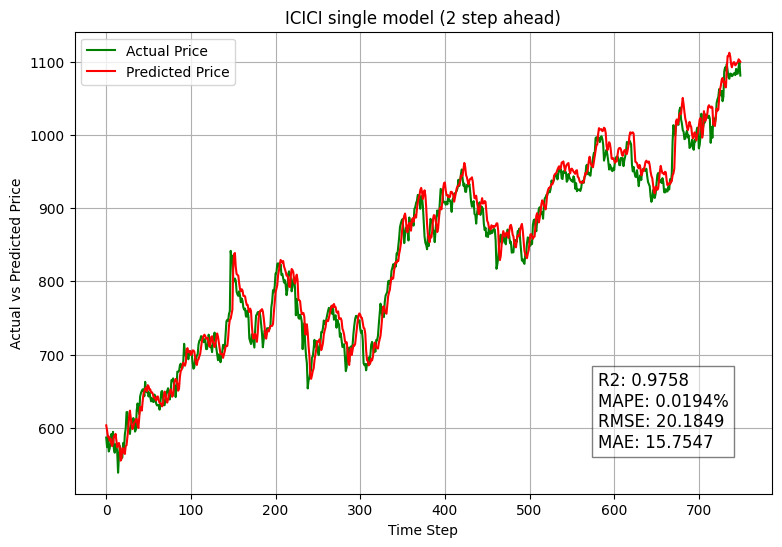

In [6]:
plt.figure(figsize=(9, 6))
plt.plot(y_test_actual_LSTM, color='green', label=['Actual Price'])
plt.plot(predictions_LSTM, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.75, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}%\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}', 
         fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.grid(True)
plt.title('ICICI single model (2 step ahead)')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('icici_2sa-1l.png', dpi=600)  # Saves the plot as a PNG file
plt.show()

In [7]:
model_lstm.predict(X_train)

predictions_train_lstm = model_lstm.predict(X_train)
predictions_train_LSTM = scaler.inverse_transform(predictions_train_lstm)
y_train_actual_LSTM = scaler.inverse_transform(y_train.reshape(-1, 1))

r2=r2_score(y_train_actual_LSTM, predictions_train_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_train_actual_LSTM, predictions_train_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_train_actual_LSTM, predictions_train_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_train, predictions_train_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae_n=mean_absolute_error(y_train, predictions_train_lstm)
print(f"MAE_normalizeddata: {mae_n:.4f}")

mae=mean_absolute_error(y_train_actual_LSTM, predictions_train_LSTM)
print(f"MAE: {mae:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
R2: 0.9892
MAPE: 0.0324
RMSE: 11.1530
RMSE_normalizeddata: 0.0106
MAE_normalizeddata: 0.0074
MAE: 7.7756


In [29]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(412, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=39, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

               
predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 38s 103ms/step - loss: 0.0094 - val_loss: 0.0017
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 2.0441e-04 - val_loss: 0.0014
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 1.7613e-04 - val_loss: 0.0011
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 1.8276e-04 - val_loss: 0.0013
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 1.8284e-04 - val_loss: 0.0013
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 1.5844e-04 - val_loss: 0.0013
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 1.9605e-04 - val_loss: 0.0013
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 1.5216e-04 - val_loss: 0.0011
Epoch 9/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 1.3491e-04 - val_loss: 0.0012
Epoch 10/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 1.9743e-04 - val_loss: 0.0011
Epoch 11/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 1.6913e-04 - val_loss: 0.0011
Epoch 12/2

In [30]:
model_lstm.save('model_lstm_bajajfin2_1.keras')

In [31]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(412, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=39, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 77s 171ms/step - loss: 0.0109 - val_loss: 0.0011
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - loss: 1.8174e-04 - val_loss: 0.0012
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 1.6207e-04 - val_loss: 0.0013
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 1.5235e-04 - val_loss: 0.0019
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 1.6542e-04 - val_loss: 0.0011
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 1.7030e-04 - val_loss: 0.0017
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 1.7255e-04 - val_loss: 0.0012
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 1.5564e-04 - val_loss: 0.0012
Epoch 9/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 1.3272e-04 - val_loss: 0.0013
Epoch 10/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 1.5945e-04 - val_loss: 0.0011
Epoch 11/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 1.7597e-04 - val_loss: 0.0011
Epoch 12

In [32]:
model_lstm.save('model_lstm_bajajfin2_2.keras')

In [33]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(412, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=39, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - loss: 0.0121 - val_loss: 0.0012
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.8243e-04 - val_loss: 0.0013
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 2.2067e-04 - val_loss: 0.0014
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 1.9801e-04 - val_loss: 0.0013
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 1.8105e-04 - val_loss: 0.0012
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.5361e-04 - val_loss: 0.0013
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.4284e-04 - val_loss: 0.0013
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 1.4817e-04 - val_loss: 0.0014
Epoch 9/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 1.4947e-04 - val_loss: 0.0011
Epoch 10/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 1.4800e-04 - val_loss: 0.0013
Epoch 11/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 1.8103e-04 - val_loss: 0.0011
Epoch 12/20

In [34]:
model_lstm.save('model_lstm_bajajfin2_3.keras')

In [35]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(412, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=39, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.0122 - val_loss: 0.0014
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 1.8184e-04 - val_loss: 0.0011
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 1.5379e-04 - val_loss: 0.0016
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 1.9060e-04 - val_loss: 0.0013
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 1.5318e-04 - val_loss: 0.0028
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 1.6071e-04 - val_loss: 0.0012
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 1.9051e-04 - val_loss: 0.0015
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 1.7584e-04 - val_loss: 0.0030
Epoch 9/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 1.6904e-04 - val_loss: 0.0012
Epoch 10/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 1.3172e-04 - val_loss: 0.0015
Epoch 11/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 1.6736e-04 - val_loss: 0.0011
Epoch 12/2

In [36]:
model_lstm.save('model_lstm_bajajfin2_4.keras')

In [37]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(412, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=39, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - loss: 0.0144 - val_loss: 0.0014
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 1.7750e-04 - val_loss: 0.0016
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 1.5761e-04 - val_loss: 0.0014
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 1.3679e-04 - val_loss: 0.0017
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 1.5057e-04 - val_loss: 0.0014
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 1.6730e-04 - val_loss: 0.0013
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 1.5089e-04 - val_loss: 0.0015
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 1.6824e-04 - val_loss: 0.0015
Epoch 9/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 1.6492e-04 - val_loss: 0.0012
Epoch 10/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 1.7594e-04 - val_loss: 0.0012
Epoch 11/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 1.6646e-04 - val_loss: 0.0011
Epoch 12/20

In [38]:
model_lstm.save('model_lstm_bajajfin2_5.keras')

In [39]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(412, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=39, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - loss: 0.0112 - val_loss: 0.0014
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 1.5410e-04 - val_loss: 0.0016
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 1.7081e-04 - val_loss: 0.0012
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 1.5672e-04 - val_loss: 0.0011
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 1.8772e-04 - val_loss: 0.0019
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 1.9114e-04 - val_loss: 0.0015
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 1.3008e-04 - val_loss: 0.0012
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 1.5786e-04 - val_loss: 0.0011
Epoch 9/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.5379e-04 - val_loss: 0.0012
Epoch 10/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 1.3755e-04 - val_loss: 0.0013
Epoch 11/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 1.3546e-04 - val_loss: 0.0012
Epoch 12/2

In [40]:
model_lstm.save('model_lstm_bajajfin2_6.keras')

In [41]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(412, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=39, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])
predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - loss: 0.0107 - val_loss: 0.0012
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 1.7964e-04 - val_loss: 0.0012
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 1.6104e-04 - val_loss: 0.0012
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 1.4525e-04 - val_loss: 0.0012
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 1.7929e-04 - val_loss: 0.0012
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.7602e-04 - val_loss: 0.0014
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 1.8290e-04 - val_loss: 0.0021
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 2.0245e-04 - val_loss: 0.0013
Epoch 9/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 1.9409e-04 - val_loss: 0.0017
Epoch 10/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.6948e-04 - val_loss: 0.0013
Epoch 11/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 1.8011e-04 - val_loss: 0.0012
Epoch 12/20

In [42]:
model_lstm.save('model_lstm_bajajfin2_7.keras')

In [43]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(412, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=39, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])
predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 26s 109ms/step - loss: 0.0132 - val_loss: 0.0013
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 2.0837e-04 - val_loss: 0.0017
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 1.4795e-04 - val_loss: 0.0014
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 1.8982e-04 - val_loss: 0.0013
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 1.6624e-04 - val_loss: 0.0012
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 1.5331e-04 - val_loss: 0.0012
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 1.5382e-04 - val_loss: 0.0015
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 1.5773e-04 - val_loss: 0.0012
Epoch 9/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 1.7551e-04 - val_loss: 0.0012
Epoch 10/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 1.5863e-04 - val_loss: 0.0012
Epoch 11/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 1.7061e-04 - val_loss: 0.0011
Epoch 12/2

In [44]:
model_lstm.save('model_lstm_bajajfin2_8.keras')

In [45]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(412, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=39, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 38s 116ms/step - loss: 0.0137 - val_loss: 0.0038
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 1.6304e-04 - val_loss: 0.0013
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 1.7240e-04 - val_loss: 0.0012
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 1.5755e-04 - val_loss: 0.0014
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 1.6284e-04 - val_loss: 0.0016
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 1.5824e-04 - val_loss: 0.0021
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 1.8289e-04 - val_loss: 0.0011
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 1.5229e-04 - val_loss: 0.0022
Epoch 9/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 1.6895e-04 - val_loss: 0.0017
Epoch 10/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 1.7169e-04 - val_loss: 0.0016
Epoch 11/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 1.3723e-04 - val_loss: 0.0011
Epoch 12/2

In [46]:
model_lstm.save('model_lstm_bajajfin2_9.keras')

In [47]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(412, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.001), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=39, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 33s 100ms/step - loss: 0.0127 - val_loss: 0.0013
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 1.7705e-04 - val_loss: 0.0016
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 1.8171e-04 - val_loss: 0.0012
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 1.6123e-04 - val_loss: 0.0012
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 1.8336e-04 - val_loss: 0.0014
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 1.8005e-04 - val_loss: 0.0011
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 1.2824e-04 - val_loss: 0.0012
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 1.8312e-04 - val_loss: 0.0011
Epoch 9/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 1.3119e-04 - val_loss: 0.0016
Epoch 10/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 1.3746e-04 - val_loss: 0.0013
Epoch 11/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 1.4379e-04 - val_loss: 0.0011
Epoch 12/2

In [48]:
predictions_train_lstm = model_lstm.predict(X_train)
predictions_train_LSTM = scaler.inverse_transform(predictions_train_lstm)
y_train_actual_LSTM = scaler.inverse_transform(y_train.reshape(-1, 1))

r2=r2_score(y_train_actual_LSTM, predictions_train_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_train_actual_LSTM, predictions_train_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_train_actual_LSTM, predictions_train_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_train, predictions_train_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae_n=mean_absolute_error(y_train, predictions_train_lstm)
print(f"MAE_normalizeddata: {mae_n:.4f}")

mae=mean_absolute_error(y_train_actual_LSTM, predictions_train_LSTM)
print(f"MAE: {mae:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
R2: 0.9964
MAPE: 0.1149
RMSE: 83.6693
RMSE_normalizeddata: 0.0102
MAE_normalizeddata: 0.0050
MAE: 40.5207


In [49]:
model_lstm.save('model_lstm_bajajfin2_10.keras')